In [1]:
import configparser
import os.path
import re
from sys import stdout,stderr
import bitarray
import math, pprint, argparse, time
from functools import reduce

import joblib
import scipy
from scipy import ndimage, signal, interpolate
import csv
from pylab import *

from petsysbuild.petsys import tofpet2b, tofpet2c, fe_power, daqd, config

# parser = argparse.ArgumentParser(description='Acquire data for threshold calibration')
# parser.add_argument("--config", type=str, required=True, help="Configuration file")
# parser.add_argument("-o", type=str, dest="outFilePrefix", required=True, help="Data file prefix")
# parser.add_argument("--nreads-noise", dest="noise_reads", type=int, required=False, default=4)
# parser.add_argument("--nreads-dark", dest="dark_reads", type=int, required=False, default=4)
# parser.add_argument("--ext-bias", dest="ext_bias", action="store_true", default=False, help="Prompt user to set bias")
# args = parser.parse_args()


#######################################################
## INPUT ARGS
#######################################################

class args:
	data_dir = "/mnt/sda2/tofpet_data/test_stand_init/"
	config = f"{data_dir}/config.ini"
	output = f"{data_dir}/disc_staircase_all_channels_temp_"
	dark_reads = 2 # Each counter period is 0.08s, 5 reads->0.4s
	
	disc_lsb_t1 = 55
	disc_lsb_t2 = 55
	disc_lsb_e = 48  # Default is 40

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setup DAQ driver

In [2]:
# Some constant numbers
# Counter period is set to 0b111 = 2^24 cycles
COUNT_MAX = 1.0 * (2**24)
BIAS_ON = True

TriggerList = [ 
	(0,  "vth_t1", [0,0,0,0]),
	(1,  "vth_t2", [0,0,1,3]),
	(2,  "vth_e",  [3,2,2,2])
]


#######################
# DAQ setup
# Open daqd driver
idaqd = daqd.Connection()
idaqd.initializeSystem()
CLK_FREQ = idaqd.getSystemFrequency()
T = COUNT_MAX * (1 / CLK_FREQ)
counter_sharing = 1
print("* System CLK frequency: ",CLK_FREQ)

# Get active Asics and Channels
activeAsics = idaqd.getActiveAsics()
activeChannels = [ (portID, slaveID, chipID, channelID) for channelID in range(64) for portID, slaveID, chipID in activeAsics ]

# Apply configuration file
systemConfig = config.ConfigFromFile(args.config, loadMask=config.LOAD_ALL^config.LOAD_QDCMODE_MAP)
systemConfig.loadToHardware(idaqd, bias_enable=config.APPLY_BIAS_OFF)

# Get Asic configurations
asicsConfig = idaqd.getAsicsConfig()



# Setup counter, discriminator LSB
for (portID, slaveID, chipID), ac in list(asicsConfig.items()):
	if not ac: continue
	gc = ac.globalConfig
	
	if idaqd.getAsicSubtype(portID, slaveID, chipID) == "2B":
		COUNTER_SETTING = 0x4
	else:
		COUNTER_SETTING = 0b111

	# print(portID, slaveID, chipID, COUNTER_SETTING)
	gc.setValue("counter_en", 0b1)
	gc.setValue("counter_period", COUNTER_SETTING)
	gc.setValue("disc_lsb_t1", args.disc_lsb_t1)
	gc.setValue("disc_lsb_t2", args.disc_lsb_t2)
	gc.setValue("disc_lsb_e", args.disc_lsb_e)

	for cc in ac.channelConfig:
		cc.setValue("trigger_mode_1", 0)
		cc.setValue("counter_mode", 0x2) # Count valid events
		cc.setValue("trigger_b_latched", 0)

INFO: active units on ports:  0
INFO: Evaluation kit: FEB/D with GBE connection @ ( 0,  0)
INFO: Setting FEM  power  ON @ (portID, slaveID) = (0,0)
INFO: FEB/D ( 0,  0) has  4 active ASICs: 0, 1, 4, 5
* System CLK frequency:  200000000.0
INFO: Setting BIAS power OFF @ (portID, slaveID) = (0,0)


## Take measurements

In [3]:
# ----------------------------------------------------
# Measure  trigger rate w.r.t a trigger threshold
# ----------------------------------------------------
print(f"Scanning trigger rate w.r.t. different discriminators")

if BIAS_ON:
	systemConfig.loadToHardware(idaqd, bias_enable=config.APPLY_BIAS_ON)
	print("Bias voltage turned ON!")

data_save = {}
for ind, trigger_type, trigger_mode_setting in TriggerList:
	# if ind!=0:
	# 	continue

	stdout.write(f"  {trigger_type}"); stdout.flush()

	outdata = {}
	for portID, slaveID, chipID in activeAsics:
		outdata[(portID, slaveID, chipID)] = {}
		for channelID in range(len(asicsConfig[(portID, slaveID, chipID)].channelConfig)):
			outdata[(portID, slaveID, chipID)][channelID]={}
			for thresholdValue in range(0,62):
				outdata[(portID, slaveID, chipID)][channelID][thresholdValue]=[]

	for thresholdValue in range(0,62):
		for portID, slaveID, chipID, channelID in activeChannels:
			cc = asicsConfig[(portID, slaveID, chipID)].channelConfig[channelID]

			dac_setting = systemConfig.mapAsicChannelThresholdToDAC((portID, slaveID, chipID, channelID), trigger_type, int(thresholdValue))

			cc.setValue(trigger_type, dac_setting) # Set threshold
			cc.setValue("trigger_mode_2_t", trigger_mode_setting[0])    # Set trigger to be single threshold on t1
			cc.setValue("trigger_mode_2_q", trigger_mode_setting[1])
			cc.setValue("trigger_mode_2_e", trigger_mode_setting[2])
			cc.setValue("trigger_mode_2_b", trigger_mode_setting[3])
			if ind==1:
				vth_t1_temp = systemConfig.mapAsicChannelThresholdToDAC((portID, slaveID, chipID, channelID), "vth_t1", 15)
				cc.setValue("vth_t1", vth_t1_temp) # For the scan of vth_t2, there is no t2 only trigger, need to set vth_t1 to a low value


		idaqd.setAsicsConfig(asicsConfig)
		time.sleep(1*T)
		next_read_start_time = time.time() + counter_sharing*T + 1E-3
		for n in range(args.dark_reads):
			s = next_read_start_time - time.time()
			if s > 0: time.sleep(s)
			next_read_start_time = time.time() + counter_sharing*T + 1E-3
			for portID, slaveID, chipID in activeAsics:
				vv = idaqd.read_mem_ctrl(portID, slaveID, 5, 24, 64*chipID, 64)
				for channelID, v in enumerate(vv):
					# Write out the number of triggers per second
					# -- v from vv is the counter value, divided by the max counter period T 
					v = v/T
					outdata[(portID, slaveID, chipID)][channelID][thresholdValue].append(v)

					# if chipID==4 and channelID==9:
					# 	print(v)

		stdout.write(".")
		stdout.flush()
		
	stdout.write("\n")
	data_save[trigger_type] = outdata




if BIAS_ON:
	systemConfig.loadToHardware(idaqd, bias_enable=config.APPLY_BIAS_OFF)
	print("Bias voltage turned OFF!")

Scanning trigger rate w.r.t. different discriminators
INFO: Setting BIAS power  ON @ (portID, slaveID) = (0,0)
Bias voltage turned ON!
  vth_t1..............................................................
  vth_t2..............................................................
  vth_e..............................................................
INFO: Setting BIAS power OFF @ (portID, slaveID) = (0,0)
Bias voltage turned OFF!


## Plot and save

Found 80 channels


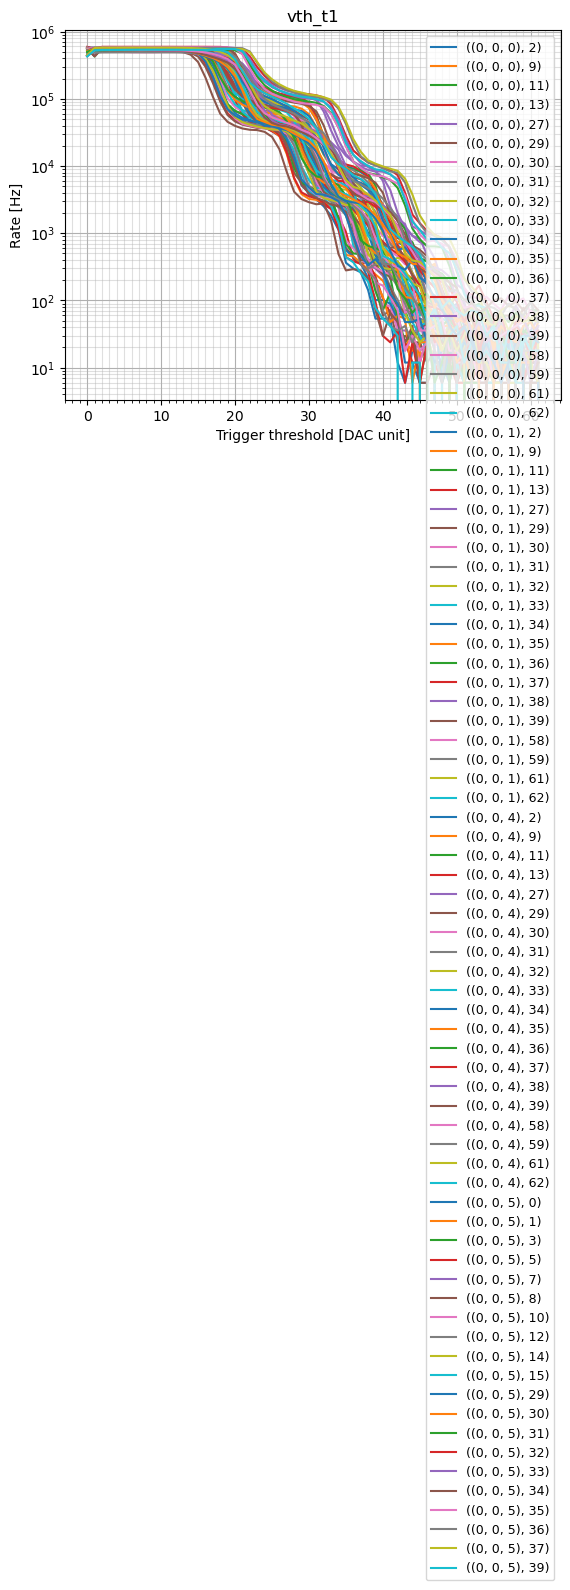

Found 80 channels


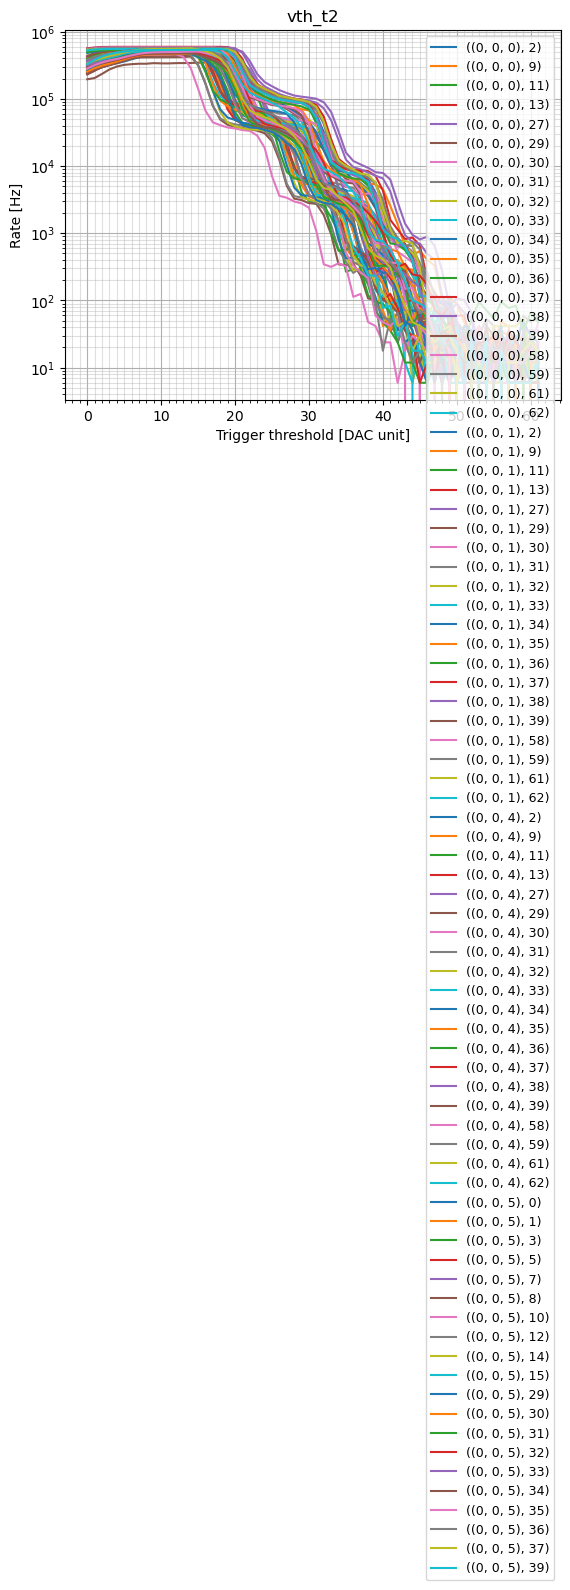

Exception: Not enough peaks found, cannot set threshold

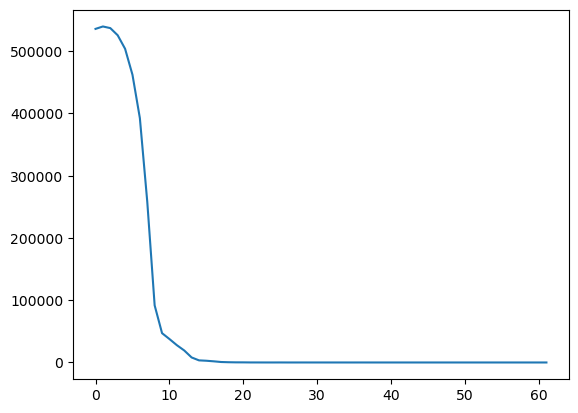

In [8]:
# portID, slaveID, chipID, channelID = 0,0,4,9
# outdata[(portID, slaveID, chipID)][channelID]

def process_staircase_threshold(thresholds, trigger_rate, target_npe):
    """
    calculate the threshold at given rate

    INPUT:
    
    """
    trigger_rate_diff = -scipy.ndimage.gaussian_filter(trigger_rate, sigma=1.2, order=1)

    # Interpolate
    trigger_rate_curve = scipy.interpolate.interp1d(thresholds, trigger_rate_diff, kind="quadratic")
    thresholds_interp = np.linspace(thresholds[0], thresholds[-1], 512)
    rate_inter = trigger_rate_curve(thresholds_interp)
    # Find peaks
    peaks, prop = scipy.signal.find_peaks(rate_inter, 
                                            height = max(rate_inter)/300, prominence = max(rate_inter)/300)   
    if len(peaks)<2:
        raise Exception("Not enough peaks found, cannot set threshold")


    # Use the largest two peaks as first and second pe peak
    inds_sort = np.argsort(prop["peak_heights"])
    peaks_sorted = np.array(peaks)[inds_sort[::-1]]
    baseline = 2*thresholds_interp[peaks_sorted[0]] - thresholds_interp[peaks_sorted[1]]
    amp_1pe = thresholds_interp[peaks_sorted[1]] - thresholds_interp[peaks_sorted[0]]


    # plot(thresholds_interp, rate_inter) 
    # axvline(baseline)
    # axvline(baseline+1.5*amp_1pe)
    return baseline + target_npe*amp_1pe

def plot_staircase(data, chips=None, channels = None, plot_preselect=True, target_rate=None, target_npe=None):
    chips = list(data.keys()) if chips is None else chips
    channels = data[chips[0]].keys() if channels is None else channels

    curve_save = {}
    channels_info= {}
    channel_count=0
    for chip in chips:
        for ch in channels:
            thresholds = list(data[chip][ch].keys())
            trigger_rate = [np.mean(data[chip][ch][th]) for th in data[chip][ch].keys()]

            if plot_preselect and np.max(trigger_rate[12:])>0 or not plot_preselect:
                channels_info[chip+(ch,)] = {}

                plot(thresholds, trigger_rate, label = f"{chip,ch}")
                channel_count+=1
                curve_save[chip+(ch,)] = [thresholds, trigger_rate]

                # Find threshold at given rate
                if target_rate is not None:
                    threshold_set = thresholds[trigger_rate<target_rate]
                    channels_info[chip+(ch,)]["threshold_at_rate"] = threshold_set

                # Find threshold at given number of photo-electrons (target_npe)
                if target_npe is not None and  1<target_npe<20:
                    threshold_npe = process_staircase_threshold(thresholds, trigger_rate, target_npe)
                    channels_info[chip+(ch,)]["threshold_npe"] = int(round(threshold_npe))

    print(f"Found {channel_count} channels")

    yscale("log")
    xlabel("Trigger threshold [DAC unit]")
    ylabel("Rate [Hz]")
    gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    gca().xaxis.set_major_locator(plt.MultipleLocator(10))
    grid(which="major")
    grid(which="minor", alpha=0.4)
    legend(loc="best", fontsize=9)
    return curve_save, channels_info

def update_disc(filename, channel_info, verbose=False):
    threshold_row_map = {
    "vth_t1": 4,
    "vth_t2": 5,
    "vth_e": 6,
    }

    # Open the file
    with open(filename, 'r') as f:
        output = [f.readline()]
        for line in f:
            output.append(line)


    # Update the content
    for key in channel_info:
        info = channel_info[key]
        threshold_row = threshold_row_map[key]

        for ch in info:
            for iline in range(1, len(output)):
                line = output[iline]
                content = [int(ii) for ii in line.split("\t")]
                if tuple(content[:4])==ch:
                    content[threshold_row] = info[ch]["threshold_npe"]
                    output[iline] = reduce(lambda x, y: str(x) + '\t' + str(y), content)+"\n"
                    continue


    # Write the file
    os.rename(filename, filename+".backup")
    with open(filename, 'w', newline='') as f:
        f.writelines(output)



def process_staircase_offset(curve_save_all, ref_channel = (0,0,4,9), ref_rate=0.5):
    """
    calculate the baseline offset of each channel relative to the ref_channel

    INPUT:
    ref_channel: tuple, (portID, slaveID, chipID, channelID)
    ref_rate   : fraction of the maximum rate to align the curves
    
    """
    for disc_type in curve_save_all:
        print("Zero of",disc_type,":")
        curves = curve_save_all[disc_type]

        max_rate_min = np.min([max(curves[i][1]) for i in curves.keys()])
        rate_to_align = max_rate_min* ref_rate
        threshold_value_when_passing_aligning_rate = np.array([curves[i][0][np.argmax(curves[i][1]<rate_to_align)] for i in curves.keys()])
        print("  Threshold at half maximum rate", threshold_value_when_passing_aligning_rate)
        threshold_of_ref_channel = None
        for i, ch in enumerate(curves.keys()):
            if ch==ref_channel:
                threshold_of_ref_channel = threshold_value_when_passing_aligning_rate[i]
        for i, ch in enumerate(curves.keys()):
            print("  channel", ch, "need to be shifted by", -(threshold_value_when_passing_aligning_rate[i]-threshold_of_ref_channel))








##################################################
# Process and save
##################################################
# Save Raw
joblib.dump(data_save, args.output+"rawdata.joblib")

# Save plots
target_threshold_list_npe = {
"vth_t1": 1.5,
"vth_t2": 2.5,
"vth_e": 4.5,
}

curve_save_all ={}
channels_info_all = {}
for key in data_save:
    curve_save, channels_info = plot_staircase(data_save[key], chips = None, channels =None, target_npe=target_threshold_list_npe[key])
    # curve_save, channels_info = plot_staircase(data_save[key], chips = None, channels =None, target_npe=None)
    title(key)
    savefig(args.output+f"{key}.jpg")
    show()

    curve_save_all[key] = curve_save
    channels_info_all[key] = channels_info
    
# Save plot data
joblib.dump(data_save, args.output+"curves.joblib")

# Update threshold info to the config file
update_disc(args.data_dir+"/disc_settings.tsv", channels_info_all)


# Process the curves, find the offset on x axis'
# ********** Use these numbers to change the "zeros" in "disc_calibration.tsv" file
# process_staircase(curve_save_all,  ref_channel = (0,0,4,9), ref_rate=0.5)

In [5]:
ch_pairs = np.loadtxt("configurations/coinc_pairs.csv", delimiter=",")

In [6]:
list(channels_info.keys())[0]

(0, 0, 0, 2)

In [7]:
for pair in ch_pairs:
    for ch in pair:
        detected=False
        # print("checking", ch)
        for ch_detected  in channels_info.keys():
            # print(ch_detected[2]*64+ch_detected[3]==ch)
            if ch_detected[2]*64+ch_detected[3]==ch:
                detected=True
                break
        if detected==False:
            print(ch)
